<a href="https://colab.research.google.com/github/jkranyak/project_3/blob/second_model/latest_efficient_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install tensorflow
!pip install isic-cli
!pip install kaggle
# !pip install imblearn

In [22]:
import os
# Specify the current path of kaggle.json file
current_path = '/content/kaggle.json'

# Desired path where the Kaggle API expects the kaggle.json file
desired_path = '/root/.kaggle/kaggle.json'

if os.path.exists(current_path):
    os.makedirs(os.path.dirname(desired_path), exist_ok=True)
    os.rename(current_path, desired_path)

    # Set the file's permissions to avoid a permissions error
    os.chmod(desired_path, 0o600)
else:
    print(f"Error: '{current_path}' does not exist. Please upload the file.")



Error: '/content/kaggle.json' does not exist. Please upload the file.


In [23]:
! isic user login

Hello jessekranyak@gmail.com!


In [24]:
!kaggle datasets download -d andrewmvd/isic-2019


isic-2019.zip: Skipping, found more recently modified local copy (use --force to force download)


In [25]:
!unzip -q isic-2019.zip


replace ISIC_2019_Training_GroundTruth.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [26]:
!pip install scikit-learn

In [27]:
import numpy as np
import pandas as pd
import sklearn.utils.class_weight
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, OneHotEncoder



https://www.nature.com/articles/s41598-021-96707-8

get the data over here

run all the same cells and augment by resampling the data like we did in model 1


In [28]:
metadata = pd.read_csv('/content/challenge-2019-training_metadata_2024-04-17.csv')
metadata.rename(columns={'isic_id': 'image'}, inplace=True)
# Define the new base path for the images
base_path = Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input')

# Create the full image paths
metadata['image_path'] = metadata['image'].apply(lambda x: base_path / f"{x}.jpg")

# Example of how to display the first few image paths
print(metadata[['image', 'image_path']].head())

<ipython-input-28-1c578a8e213b>:1: DtypeWarning: Columns (8,11,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/content/challenge-2019-training_metadata_2024-04-17.csv')


          image                                         image_path
0  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3  ISIC_0000000  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4  ISIC_0000001  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...


In [29]:
metadata['image_path'].head()

0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object

In [30]:
# Drop the specified columns
metadata.drop(columns=['copyright_license', 'attribution'], inplace=True)
# Rename the column
metadata.rename(columns={'isic_id': 'image'}, inplace=True)
metadata.drop_duplicates(inplace=True)
metadata.head()

,image,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,image_type,lesion_id,melanocytic,nevus_type,patient_id,personal_hx_mm,sex,image_path
0,ISIC_0000000,55.0,anterior torso,benign,NaN,False,NaN,nevus,NaN,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,female,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4,ISIC_0000001,30.0,anterior torso,benign,NaN,False,NaN,nevus,NaN,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,female,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
8,ISIC_0000002,60.0,upper extremity,malignant,NaN,True,NaN,melanoma,histopathology,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,female,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
12,ISIC_0000003,30.0,upper extremity,benign,NaN,False,NaN,nevus,NaN,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,male,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...
16,ISIC_0000004,80.0,posterior torso,malignant,NaN,True,NaN,melanoma,histopathology,NaN,dermoscopic,NaN,True,NaN,NaN,NaN,male,/content/ISIC_2019_Training_Input/ISIC_2019_Tr...


In [31]:
metadata.shape

(25331, 18)

In [32]:
# Load the data from the file into a DataFrame
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')

# Display the first few rows of the DataFrame
ground_truth.shape

(25331, 10)

In [33]:
image_dir = Path('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input')
ground_truth['image_path'] = ground_truth['image'].apply(lambda x: image_dir / f"{x}.jpg")

# Merge the ground_truth with metadata if necessary
full_metadata = pd.merge(ground_truth, metadata, on='image', how='left')  # Adjust 'on' parameter as needed
full_metadata.shape

(25331, 28)

In [34]:
# Correct the base path in 'image_path' column
correct_base_path = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

full_metadata['image_path'] = full_metadata['image'].apply(lambda x: f"{correct_base_path}/{x}.jpg")

# Verify the correction by printing the first few entries again
print(full_metadata['image_path'].head())

0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object


In [35]:
full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image                   25331 non-null  object 
 1   MEL                     25331 non-null  float64
 2   NV                      25331 non-null  float64
 3   BCC                     25331 non-null  float64
 4   AK                      25331 non-null  float64
 5   BKL                     25331 non-null  float64
 6   DF                      25331 non-null  float64
 7   VASC                    25331 non-null  float64
 8   SCC                     25331 non-null  float64
 9   UNK                     25331 non-null  float64
 10  image_path_x            25331 non-null  object 
 11  age_approx              22989 non-null  float64
 12  anatom_site_general     21374 non-null  object 
 13  benign_malignant        15710 non-null  object 
 14  clin_size_long_diam_mm  556 non-null  

In [36]:
# Fill missing values for 'age_approx' with its median
full_metadata['age_approx'].fillna(full_metadata['age_approx'].median(), inplace=True)

# For categorical data, fill missing values with 'unknown'
full_metadata['anatom_site_general'].fillna('unknown', inplace=True)
full_metadata['sex'].fillna('unknown', inplace=True)
full_metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image                   25331 non-null  object 
 1   MEL                     25331 non-null  float64
 2   NV                      25331 non-null  float64
 3   BCC                     25331 non-null  float64
 4   AK                      25331 non-null  float64
 5   BKL                     25331 non-null  float64
 6   DF                      25331 non-null  float64
 7   VASC                    25331 non-null  float64
 8   SCC                     25331 non-null  float64
 9   UNK                     25331 non-null  float64
 10  image_path_x            25331 non-null  object 
 11  age_approx              25331 non-null  float64
 12  anatom_site_general     25331 non-null  object 
 13  benign_malignant        15710 non-null  object 
 14  clin_size_long_diam_mm  556 non-null  

In [37]:
# Sample DataFrame
data = {
    'image_path_x': ['path1.jpg', 'path2.jpg', 'path3.jpg'],
    'image_path_y': ['path1.jpg', 'path2.jpg', 'path3.jpg'],
    'image_path': ['path1.jpg', 'path2.jpg', 'path4.jpg']  # Notice the discrepancy in the last row
}
df = full_metadata

# Step 1: Consolidate columns into one
df['consolidated_path'] = df.apply(lambda x: x.dropna().unique()[0] if len(x.dropna().unique()) == 1 else None, axis=1)

# Step 2: Identify discrepancies
df['is_discrepant'] = df.apply(lambda x: len(x.dropna().unique()) != 1, axis=1)

# Step 3: Count discrepancies
discrepancy_count = df['is_discrepant'].sum()

# Step 4: Report discrepancies
discrepancy_report = df[df['is_discrepant']]

print("Number of discrepancies:", discrepancy_count)
print("Discrepancy report:")
print(discrepancy_report[['image_path_x', 'image_path_y', 'image_path', 'consolidated_path']])

Number of discrepancies: 25331
Discrepancy report:
                                            image_path_x  \
0      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
1      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
2      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
3      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
4      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
...                                                  ...   
25326  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25327  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25328  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25329  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
25330  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   

                                            image_path_y  \
0      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
1      /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
2      /content/ISIC_2019_Training_Input/ISIC_20

In [38]:
import pandas as pd

# Define a function to convert PosixPath to string and extract the last part of the paths
def detail_discrepancies(row):
    # Convert PosixPath to string and then get the last 30 characters of each path
    x_end = str(row['image_path_x'])[-30:]
    y_end = str(row['image_path_y'])[-30:]
    path_end = str(row['image_path'])[-30:]

    if x_end != y_end or x_end != path_end:
        return f"X vs Y: {x_end} != {y_end}, X vs Path: {x_end} != {path_end}"
    return None

# Apply this function to a new column
full_metadata['discrepancy_details'] = full_metadata.apply(detail_discrepancies, axis=1)

# Filter to show only rows with discrepancies and limit the output
discrepancy_details = full_metadata[full_metadata['discrepancy_details'].notna()].head(10)

print("Detailed discrepancies (first 10 cases focusing on path endings):")
print(discrepancy_details[['image_path_x', 'image_path_y', 'image_path', 'discrepancy_details']])


Detailed discrepancies (first 10 cases focusing on path endings):
                                         image_path_x image_path_y  \
16  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
17  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
18  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
19  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
20  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
21  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
22  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
23  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
24  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   
25  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...          NaN   

                                           image_path  \
16  /content/ISIC_2019_Training_Input/ISIC_2019_Tr...   
17  /content/ISIC_2019_Training_Input/ISIC_2019_T

In [39]:
full_metadata = pd.get_dummies(full_metadata, columns=['anatom_site_general','benign_malignant', 'sex'])


In [49]:
anatom_site_columns = [col for col in full_metadata.columns if col.startswith('anatom_site_general_')]
#benign_malignant_columns = [col for col in full_metadata.columns if col.startswith('benign_malignant_')]

print("One-hot encoded columns for 'anatom_site_general':")
full_metadata.head()


One-hot encoded columns for 'anatom_site_general':


,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,age_approx,...,anatom_site_general_palms/soles,anatom_site_general_posterior torso,anatom_site_general_unknown,anatom_site_general_upper extremity,benign,malignant,sex_female,sex_male,sex_unknown,target
image,,,,,,,,,,,,,,,,,,,,,
ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,...,0,0,0,0,1,0,1,0,0,0
ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,...,0,0,0,0,1,0,1,0,0,0
ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,...,0,0,0,1,0,1,1,0,0,1
ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,...,0,0,0,1,1,0,0,1,0,0
ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,...,0,1,0,0,0,1,0,1,0,1


In [43]:
# # Rename the one-hot encoded 'benign_malignant' columns
# full_metadata.rename(columns={
#     'benign_malignant_benign': 'benign',
#     'benign_malignant_indeterminate/benign': 'indeterminate_benign',
#     'benign_malignant_malignant': 'malignant'
# }, inplace=True)

# # Sum the 'indeterminate_benign' and 'malignant' columns to create a single 'malignant' column
# full_metadata['malignant'] = full_metadata['indeterminate_benign'] + full_metadata['malignant']

# # Convert any values greater than 1 back to 1 (if there's any overlapping)
# full_metadata['malignant'] = full_metadata['malignant'].clip(upper=1)

# # Drop the now unnecessary 'indeterminate_benign' column as it has been merged into 'malignant'
# full_metadata.drop(columns='indeterminate_benign', inplace=True)

# # Verify the changes
# print(full_metadata[['benign', 'malignant']].head())
# full_metadata.info()

KeyError: 'indeterminate_benign'

In [44]:
# Replace True and False with 1 and 0 respectively
full_metadata.replace({True: 1, False: 0}, inplace=True)

# Drop the specified columns
columns_to_drop = ['diagnosis', 'nevus_type','patient_id', 'dermoscopic_type', 'diagnosis_confirm_type', 'image_type', 'image_path_x', 'image_path_y', 'lesion_id']
full_metadata.drop(columns_to_drop, axis=1, inplace=True)

# Perform Label Encoding for the specified columns
label_encoder = LabelEncoder()
for column in ['concomitant_biopsy', 'family_hx_mm', 'melanocytic', 'personal_hx_mm', 'discrepancy_details', 'consolidated_path']:
    full_metadata[column] = label_encoder.fit_transform(full_metadata[column])

full_metadata = full_metadata.set_index('image')

# Displaying the modified DataFrame
print(full_metadata.head())

              MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK  age_approx  ...  \
image                                                                   ...   
ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        55.0  ...   
ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        30.0  ...   
ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        60.0  ...   
ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        30.0  ...   
ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        80.0  ...   

              anatom_site_general_oral/genital  \
image                                            
ISIC_0000000                                 0   
ISIC_0000001                                 0   
ISIC_0000002                                 0   
ISIC_0000003                                 0   
ISIC_0000004                                 0   

              anatom_site_general_palms/soles  \
image                                         

In [45]:
label_encoder = LabelEncoder()
for column in ['age_approx']:
    full_metadata[column] = label_encoder.fit_transform(full_metadata[column])


full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25331 entries, ISIC_0000000 to ISIC_0073254
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   MEL                                  25331 non-null  float64
 1   NV                                   25331 non-null  float64
 2   BCC                                  25331 non-null  float64
 3   AK                                   25331 non-null  float64
 4   BKL                                  25331 non-null  float64
 5   DF                                   25331 non-null  float64
 6   VASC                                 25331 non-null  float64
 7   SCC                                  25331 non-null  float64
 8   UNK                                  25331 non-null  float64
 9   age_approx                           25331 non-null  int64  
 10  clin_size_long_diam_mm               556 non-null    float64
 11  concomitant_bio

In [46]:
# from glob import glob

# # Load your DataFrame
# # full_metadata = pd.read_csv('path_to_your_csv.csv')  # Assuming DataFrame is loaded

# # Directory containing the images
# directory_path = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input'

# # List all files in the directory and subdirectories
# all_files = glob(os.path.join(directory_path, '**', '*'), recursive=True)

# # Function to find a matching file
# def find_matching_file(image_name):
#     # Possible filenames to search for
#     possible_filenames = [
#         os.path.join(directory_path, f"{image_name}.jpg"),
#         os.path.join(directory_path, f"{image_name}_downsampled.jpg")
#     ]

#     # Check for existence of possible files
#     for file_path in possible_filenames:
#         if file_path in all_files:
#             return file_path
#     return None  # If no file is found

# # Apply the function to create a new column with the matched file paths
# full_metadata['image_path'] = full_metadata['image'].apply(find_matching_file)

# # Check for rows where no file was found
# missing_files = full_metadata[full_metadata['image_path'].isnull()]

# # Output results
# print(f"Number of missing files: {len(missing_files)}")
# if not missing_files.empty:
#     print("Sample rows with missing files:")
#     print(missing_files[['image', 'image_path']].head())  # Adjust to display more if needed


In [52]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load your full_metadata
full_metadata['target'] = full_metadata['malignant'].astype(str)  # Convert target to string for compatibility

# Data splitting
train_val_data, test_data = train_test_split(full_metadata, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# Image Data Generators for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Setup training and validation image generators
train_img_gen = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important: do not shuffle here, the generator will handle it
)

val_img_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Custom generator to handle image and metadata inputs
class MultiInputGenerator(Sequence):
    def __init__(self, img_generator, metadata, batch_size):
        self.img_generator = img_generator
        self.metadata = metadata
        self.indices = np.arange(len(metadata))
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.metadata) / float(self.batch_size)))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs, labels = self.img_generator.__getitem__(idx)
        batch_meta = self.metadata.iloc[inds].values
        return [batch_imgs, batch_meta], labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Define the model architecture
def build_model():
    # Image input model
    image_input = Input(shape=(224, 224, 3))
    base_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights='imagenet')
    x1 = GlobalAveragePooling2D()(base_model.output)

    # Metadata input model
    metadata_input = Input(shape=(5,))
    x2 = Dense(32, activation='relu')(metadata_input)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.5)(x2)

    # Concatenate both branches
    concatenated = Concatenate()([x1, x2])
    x = Dense(64, activation='relu')(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[image_input, metadata_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


# Prepare the metadata features for training
metadata_features = ['age_approx', 'concomitant_biopsy', 'melanocytic', 'sex_male', 'sex_female']
train_metadata = train_data[metadata_features].values
val_metadata = val_data[metadata_features].values

model = build_model()
model.summary()

# Prepare training and validation generators
train_gen = MultiInputGenerator(train_img_gen, train_data[metadata_features], batch_size=32)
val_gen = MultiInputGenerator(val_img_gen, val_data[metadata_features], batch_size=32)


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_data['target'].astype(int)), y=train_data['target'].astype(int))
class_weights_dict = dict(enumerate(class_weights))


# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights_dict
)


Found 20517 validated image filenames belonging to 2 classes.
Found 2280 validated image filenames belonging to 2 classes.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_7[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


642/642 [==============================] - 1886s 3s/step - loss: 0.4987 - accuracy: 0.7315 - val_loss: 2.5453 - val_accuracy: 0.3917
Epoch 2/10
642/642 [==============================] - ETA: 0s - loss: 0.5607 - accuracy: 0.7353
Epoch 2: val_accuracy did not improve from 0.39167
642/642 [==============================] - 1853s 3s/step - loss: 0.5607 - accuracy: 0.7353 - val_loss: 2.9138 - val_accuracy: 0.2377
Epoch 3/10
642/642 [==============================] - ETA: 0s - loss: 0.5076 - accuracy: 0.7494
Epoch 3: val_accuracy improved from 0.39167 to 0.83114, saving model to best_model.h5
642/642 [==============================] - 1824s 3s/step - loss: 0.5076 - accuracy: 0.7494 - val_loss: 5.5153 - val_accuracy: 0.8311
Epoch 4/10
642/642 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.7684
Epoch 4: val_accuracy did not improve from 0.83114
642/642 [==============================] - 1812s 3s/step - loss: 0.4729 - accuracy: 0.7684 - val_loss: 0.5444 - val_accuracy:

In [57]:
model.save('/content/drive/My Drive/Colab Models')

72/72 [==============================] - 45s 624ms/step


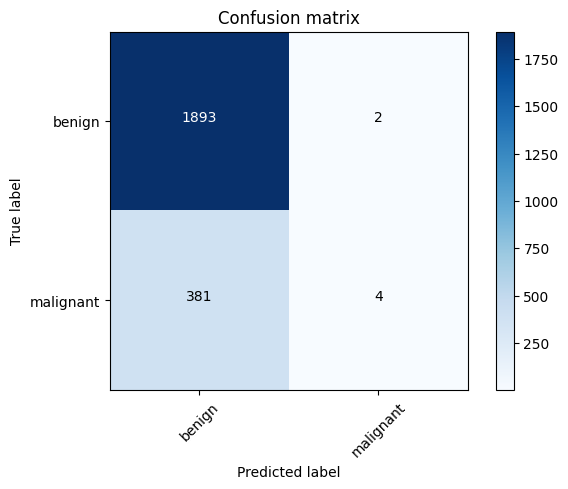

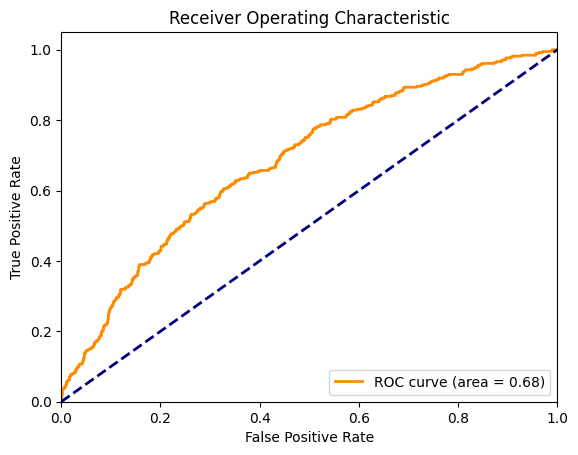

               precision    recall  f1-score   support

Non-Malignant       0.83      1.00      0.91      1895
    Malignant       0.67      0.01      0.02       385

     accuracy                           0.83      2280
    macro avg       0.75      0.50      0.46      2280
 weighted avg       0.80      0.83      0.76      2280



In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Assuming 'val_data' contains the true labels and 'predictions' contains your model's predictions
true_classes = val_data['target'].astype(int).values  # Make sure the target is binary integer

# Generate predictions
predictions = model.predict(val_gen)
predicted_classes = (predictions > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(cm, classes=['benign', 'malignant'])

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=['Non-Malignant', 'Malignant']))


In [59]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load your full_metadata
# full_metadata = pd.read_csv('path_to_your_csv_file.csv')  # Uncomment this line if you're loading from a CSV file
full_metadata['target'] = full_metadata['malignant'].astype(str)  # Convert target to string for compatibility

# Data splitting
train_val_data, test_data = train_test_split(full_metadata, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)


In [62]:
# Make sure the 'target' column is a string, this is important for the flow_from_dataframe method
train_data['target'] = train_data['malignant'].astype(str)
val_data['target'] = val_data['malignant'].astype(str)

# Image Data Generators for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Setup training and validation image generators
train_img_gen = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important: do not shuffle here, the generator will handle it
)

val_img_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 20517 validated image filenames belonging to 2 classes.
Found 2280 validated image filenames belonging to 2 classes.


In [64]:
class MultiInputGenerator(Sequence):
    def __init__(self, img_generator, metadata, batch_size):
        self.img_generator = img_generator
        self.metadata = metadata
        self.indices = np.arange(len(metadata))
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.metadata) / float(self.batch_size)))

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs, labels = self.img_generator.__getitem__(idx)
        batch_meta = self.metadata.iloc[inds].values
        return [batch_imgs, batch_meta], labels

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# Define the model architecture
def build_model():
    # Image input model
    image_input = Input(shape=(224, 224, 3))
    base_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights='imagenet')
    x1 = GlobalAveragePooling2D()(base_model.output)

    # Metadata input model
    metadata_input = Input(shape=(5,))
    x2 = Dense(32, activation='relu')(metadata_input)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.5)(x2)

    # Concatenate both branches
    concatenated = Concatenate()([x1, x2])
    x = Dense(64, activation='relu')(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[image_input, metadata_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_model()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, 224, 224, 3)          0         ['input_9[0][0]']             
                                                                                                  
 normalization_4 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_8[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_9 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_4[0][0]'

In [65]:
# Prepare the metadata features for training
metadata_features = ['age_approx', 'concomitant_biopsy', 'melanocytic', 'sex_male', 'sex_female']
train_metadata = train_data[metadata_features].values
val_metadata = val_data[metadata_features].values

# Prepare training and validation generators
train_gen = MultiInputGenerator(train_img_gen, train_data[metadata_features], batch_size=32)
val_gen = MultiInputGenerator(val_img_gen, val_data[metadata_features], batch_size=32)


In [66]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['target']),
    y=train_data['target'].astype(int)
)
class_weights_dict = dict(enumerate(class_weights))
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights_dict
)


ValueError: classes should include all valid labels that can be in y

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Let's separate features and labels first
X = full_metadata.drop(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis=1)
y = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']]  # Excluded 'UNK'

# Now, we split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the number of samples per class
class_counts = y_train.sum().sort_values(ascending=False)
print("Class counts before resampling:\n",class_counts)

# Find the maximum number of samples in any single class
max_samples = class_counts.max()




In [ ]:
# Split the X_temp and y_temp further into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Calculate the target number of samples
target_samples = int((3607 + 10308) / 2)  # adjust this as needed

# Create new DataFrame for the balanced dataset
X_train_resampled = pd.DataFrame(columns=X_train.columns)
y_train_resampled = pd.DataFrame(columns=y_train.columns)

# Iterate through each class and apply resampling
for column in y_train.columns:
    # Filter samples for the current class
    filter_mask = y_train[column] == 1
    X_class = X_train[filter_mask]
    y_class = y_train[filter_mask]

    num_samples = len(X_class)
    if num_samples > 0:
        if num_samples < target_samples:
            # Oversample minority classes
            X_class_resampled, y_class_resampled = resample(X_class, y_class,
                                                            replace=True,  # Sample with replacement
                                                            n_samples=target_samples,  # Match the target samples
                                                            random_state=42)
        else:
            # For majority or adequately represented classes, we might undersample or keep as is
            X_class_resampled, y_class_resampled = resample(X_class, y_class,
                                                            replace=False,
                                                            n_samples=target_samples,
                                                            random_state=42)

        # Append resampled data back to the overall dataset
        X_train_resampled = pd.concat([X_train_resampled, X_class_resampled], axis=0)
        y_train_resampled = pd.concat([y_train_resampled, y_class_resampled], axis=0)
    else:
        print(f"No instances to resample for class '{column}'")

# Shuffle the dataset to mix up class order (important for training)
X_train_resampled = X_train_resampled.sample(frac=1, random_state=42)
y_train_resampled = y_train_resampled.loc[X_train_resampled.index]

print("New class counts after resampling:\n", y_train_resampled.sum())


In [ ]:
# Concatenate multiple columns into a single 'labels' column
#full_metadata['labels'] = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']].idxmax(axis=1)
# Creating a single 'labels' column
class_columns = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']  # Adjust if there are different/more classes
full_metadata['labels'] = (full_metadata[class_columns] == 1).idxmax(1)
full_metadata['labels']

In [ ]:

full_metadata.info()

then run this model and lets see how it compares to our model

In [ ]:
import numpy as np
import pandas as pd
import sklearn.utils.class_weight

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'full_metadata' is already defined and loaded as shown previously
# full_metadata['labels']
# Splitting the data into training, validation, and test sets
train_val_data, test_data = train_test_split(full_metadata, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# print(train_val_data.info())

# print(train_data.info())

import os

# Sample 15 rows from your DataFrame
sample_data = train_data.sample(n=15, random_state=42)

# Iterate over each row in the sample and test the file path
for index, row in sample_data.iterrows():
    image_path = row['image_path']
    if os.path.exists(image_path):
        print(f"Image file exists: {image_path}")
    else:
        print(f"Image file not found: {image_path}")

# Prepare ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Setup generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=None,
    x_col='image_path',
    y_col='labels',  # Ensure your labels column is correctly named and formatted
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print(len(train_generator))
if train_generator is None:
    raise ValueError("`train_generator` is not defined.")
# print(train_generator.y_col)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=None,
    x_col='image_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



In [ ]:
import sklearn.utils as sku
# print(sku.compute_class_weight.__doc__)

In [ ]:
from sklearn.utils import compute_class_weight

# Calculate class weights for handling class imbalance
labels = train_data['labels'].values  # Make sure this reflects your actual labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weights = compute_class_weight('balanced', np.unique(labels), labels)
class_weights = dict(enumerate(class_weights))

# class_weights = compute_class_weight('balanced', np.unique(labels), labels)
labels_index = {label: index for index, label in enumerate(np.unique(labels))}
class_weights = {labels_index[label]: len(labels) / class_count
                 for label, class_count in zip(np.unique(labels), np.bincount([labels_index[label] for label in labels]))}
print(class_weights)

# optoinal upgraded weight distributor
# class_weights = compute_class_weight('balanced', classes=np.unique(train_data['labels']), y=train_data['labels'])
# class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

# Load DenseNet169
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ...
# Load DenseNet169
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(np.unique(labels)), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (to be defined based on your specific needs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ready to train
history = model.fit(train_generator, epochs=10, validation_data=val_generator, class_weight=class_weights)


In [ ]:
model.save('best_model_two')

In [ ]:
# Evaluate the model on the test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col='image_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Make sure not to shuffle the test data
)

print(len(test_generator))
if test_generator is None:
    raise ValueError("`test_generator` is not defined.")

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the trained model
# model.save("trained_model.h5")



# Model Interpretation (example: visualize feature importance)
# Code for interpretation goes here

# Ensemble Methods (example: stacking multiple models)
# Code for ensemble methods goes here

# Deployment (example: saving the model for deployment)
model.save("final_model_2.h5")

# Continuous Monitoring (example: monitoring model performance)
# Code for continuous monitoring goes here

# Feedback Loop (example: collect feedback and retrain model)
# Code for feedback loop goes here

# Documentation and Reporting
# Document your model architecture, training process, and results
# Write a report summarizing your findings and conclusions


In [ ]:
# Model Interpretation (example: visualize feature importance)
# Code for interpretation goes here
!pip install tf-keras-vis

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils import normalize

# Define a function to generate the Grad-CAM visualization
def generate_gradcam(model, img_array, layer_name):
    # Initialize GradCAM++ object
    gradcam = GradcamPlusPlus(model, model_modifier=None)

    # Define the loss function for Grad-CAM
    def loss(output):
        return tf.keras.backend.mean(output[:, tf.argmax(output[0])])

    # Generate Grad-CAM heatmap
    cam = gradcam(loss, img_array, penultimate_layer=layer_name)
    cam = normalize(cam)

    return cam


# Choose an image from the new data for visualization
# img_path = 'new_data_directory/image.jpg'
img_path ='/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0057266.jpg'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Choose a layer for visualization (e.g., the last convolutional layer before the GlobalAveragePooling2D layer)
layer_name = 'conv5_block32_concat'

# Generate Grad-CAM visualization
cam = generate_gradcam(model, img_array, layer_name)

# Overlay the heatmap on the original image
plt.imshow(img)
plt.imshow(cam[0], cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()


In [ ]:

# Load the original image
original_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

# Generate Grad-CAM visualization
cam = generate_gradcam(model, img_array, layer_name)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axs[0].imshow(original_img)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Plot the Grad-CAM heatmap overlaid on the original image
heatmap = axs[1].imshow(original_img)
axs[1].imshow(cam[0], cmap='jet', alpha=0.5)
axs[1].set_title('Grad-CAM Visualization')
axs[1].axis('off')

# Add colorbar for the heatmap
plt.colorbar(heatmap, ax=axs[1], orientation='horizontal')

# Show the figure
plt.tight_layout()
plt.show()
